# Analyzing models

In [24]:
import escher
from cobra.io import read_sbml_model
from cobra.flux_analysis import flux_variability_analysis
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

model = read_sbml_model('data/e_coli_core.xml.gz')

In [2]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

## Flux variablity analysis (Part 1)

Calculate all flux ranges of all reactions in the model.

In [3]:
result = flux_variability_analysis(model)

Inspect the result.

In [4]:
result

,minimum,maximum
ACALD,0.000000,0.000000
ACALDt,0.000000,0.000000
ACKr,0.000000,0.000000
ACONTa,6.007250,6.007250
ACONTb,6.007250,6.007250
...,...,...
TALA,1.496984,1.496984
THD2,0.000000,0.000000
TKT1,1.496984,1.496984
TKT2,1.181498,1.181498


Get an overview of a few key statistics of the resulting flux ranges.

In [5]:
result.describe()

,minimum,maximum
count,95.000000,95.000000
mean,2.627753,23.573766
std,10.698095,143.974430
min,-29.175827,-29.175827
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,4.959985,5.012180
max,45.514010,1000.000000


Visualize the flux ranges on a pathway map of _E. coli's_ central carbon metabolism.

In [6]:
abs_flux_ranges = abs(result.maximum - result.minimum).to_dict()
escher.Builder('e_coli_core.Core metabolism', reaction_data=abs_flux_ranges)

Builder(reaction_data={'ACALD': 0.0, 'ACALDt': 0.0, 'ACKr': 0.0, 'ACONTa': 3.375077994860476e-14, 'ACONTb': 3.…

Those reactions showing up in red are futile cyles.

In [7]:
result[result.maximum > 500]

,minimum,maximum
FRD7,0.000000,994.935624
SUCDi,5.064376,1000.000000


In [8]:
result_no_cyles = flux_variability_analysis(model)

In [9]:
abs_flux_ranges = abs(result_no_cyles.maximum - result_no_cyles.minimum).to_dict()
escher.Builder('e_coli_core.Core metabolism', reaction_data=abs_flux_ranges)

Builder(reaction_data={'ACALD': 0.0, 'ACALDt': 0.0, 'ACKr': 0.0, 'ACONTa': 7.904787935331115e-14, 'ACONTb': 7.…

## Run flux variability analysis for optimally growing _E. coli_

(Optimal) Flux Balance Analysis solutions are not necessariliy unique. Flux Variablity Analysis is a good tool for estimating the space of alternative optimal solutions.

In [10]:
fba_solution = model.optimize()

In [11]:
fba_solution.objective_value

0.8739215069684301

In [12]:
model_optimal = model.copy()

In [13]:
model_optimal.reactions.BIOMASS_Ecoli_core_w_GAM.lower_bound = fba_solution.objective_value

In [14]:
result_max_obj = flux_variability_analysis(model_optimal, loopless=True)

In [15]:
result_max_obj

,minimum,maximum
ACALD,0.000000,0.000000e+00
ACALDt,0.000000,0.000000e+00
ACKr,0.000000,0.000000e+00
ACONTa,6.007250,6.007250e+00
ACONTb,6.007250,6.007250e+00
...,...,...
TALA,1.496984,1.496984e+00
THD2,0.000000,2.415845e-13
TKT1,1.496984,1.496984e+00
TKT2,1.181498,1.181498e+00


This is actually such a common task that `flux_variability_analysis` provides an option for fixing the objective's flux at a certain percentage.

In [16]:
result_max_obj = flux_variability_analysis(model, fraction_of_optimum=1)

In [17]:
result_max_obj

,minimum,maximum
ACALD,0.000000,0.000000
ACALDt,0.000000,0.000000
ACKr,0.000000,0.000000
ACONTa,6.007250,6.007250
ACONTb,6.007250,6.007250
...,...,...
TALA,1.496984,1.496984
THD2,0.000000,0.000000
TKT1,1.496984,1.496984
TKT2,1.181498,1.181498


Turns out that in this small core metabolic model, the optimal solution is actually unique!

In [18]:
sum(abs(result_max_obj.minimum - result_max_obj.maximum))

1989.8712486770396

## Exercises (20 min)

### Exercise 1

Explore how relaxing the constraint on the growth rate affects the solution space:
1. Modify the code to explore flux ranges for $\mu \gt 0.7 \ h^{-1}$ 
1. Plot the sum of flux ranges over a range of percentages.

### Exercise 2

Using FVA, determine all blocked reactions ($v = 0$) in the model.

## Phenotypic phase plane analysis (Part 2)

Load a few packages. Cobrapy implements phenotypic phase plane calculation as well but the cameo version comes with better plotting capabilities.

In [19]:
import pandas
pandas.options.display.max_rows = 12
from cameo.flux_analysis import phenotypic_phase_plane

Compute the phenotypic phase plane for growth and acetate secretion.

In [20]:
result = phenotypic_phase_plane(model,
                                variables=[model.reactions.BIOMASS_Ecoli_core_w_GAM],
                                objective=model.reactions.EX_ac_e)

Look at the result in a tabular view.

In [21]:
result.data_frame

,BIOMASS_Ecoli_core_w_GAM,objective_lower_bound,objective_upper_bound,c_yield_lower_bound,c_yield_upper_bound,mass_yield_lower_bound,mass_yield_upper_bound
0,0.000000,0.0,20.000000,0.0,0.666667,0.0,0.655477
1,0.045996,0.0,19.300932,0.0,0.643364,0.0,0.632566
2,0.091992,0.0,18.601864,0.0,0.620062,0.0,0.609655
3,0.137988,0.0,17.902795,0.0,0.596760,0.0,0.586744
4,0.183983,0.0,17.203727,0.0,0.573458,0.0,0.563832
...,...,...,...,...,...,...,...
15,0.689938,0.0,7.906992,0.0,0.263566,0.0,0.259143
16,0.735934,0.0,6.021404,0.0,0.200713,0.0,0.197345
17,0.781930,0.0,4.014269,0.0,0.133809,0.0,0.131563
18,0.827926,0.0,2.007135,0.0,0.066904,0.0,0.065782


Plot the phenotypic phase plane showing the flux through the objective.

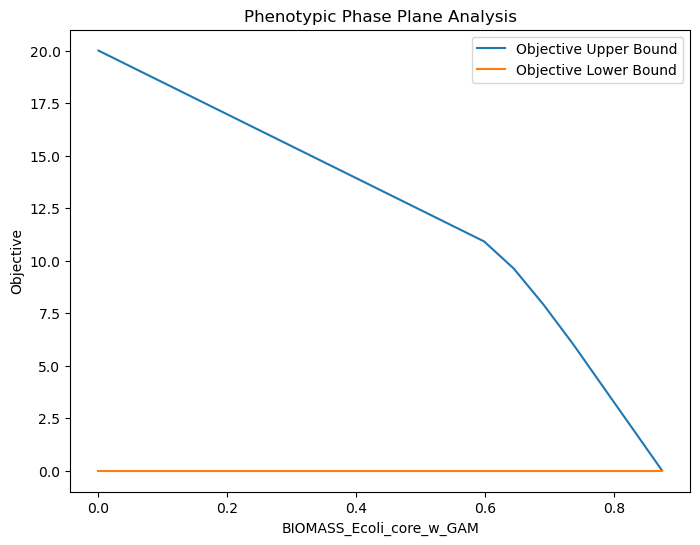

In [25]:
# Extract the data from the result
df = result.data_frame

# Plot BIOMASS vs Objective
plt.figure(figsize=(8, 6))
plt.plot(df['BIOMASS_Ecoli_core_w_GAM'], df['objective_upper_bound'], label='Objective Upper Bound')
plt.plot(df['BIOMASS_Ecoli_core_w_GAM'], df['objective_lower_bound'], label='Objective Lower Bound')
plt.xlabel('BIOMASS_Ecoli_core_w_GAM')
plt.ylabel('Objective')
plt.title('Phenotypic Phase Plane Analysis')
plt.legend()
plt.show()

We may also be interested in other parameters such as the carbon yield for output versus input at different growth rates.

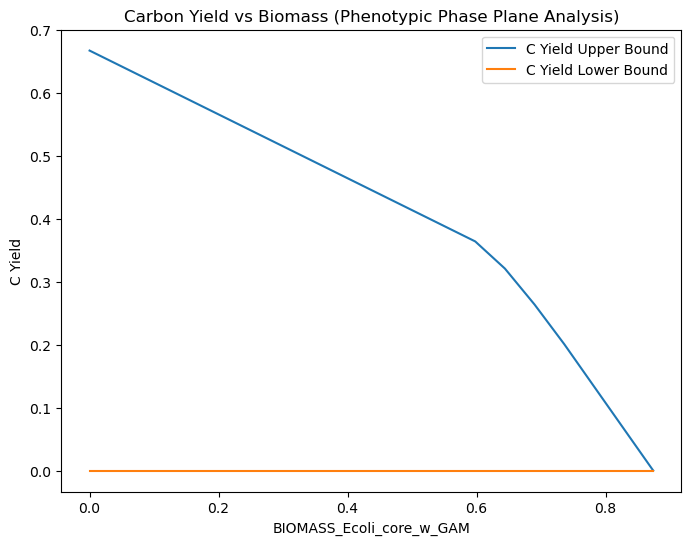

In [26]:
df = result.data_frame

# Plot BIOMASS vs Carbon Yield (upper and lower bounds)
plt.figure(figsize=(8, 6))
plt.plot(df['BIOMASS_Ecoli_core_w_GAM'], df['c_yield_upper_bound'], label='C Yield Upper Bound')
plt.plot(df['BIOMASS_Ecoli_core_w_GAM'], df['c_yield_lower_bound'], label='C Yield Lower Bound')
plt.xlabel('BIOMASS_Ecoli_core_w_GAM')
plt.ylabel('C Yield')
plt.title('Carbon Yield vs Biomass (Phenotypic Phase Plane Analysis)')
plt.legend()
plt.show()

We can also calculate a three dimensional phenotypic phase plane to compare the influence of aerobic and anaerobic environements.

In [27]:
result_3D = phenotypic_phase_plane(model, variables=[model.reactions.EX_ac_e, model.reactions.EX_o2_e],
                                   objective=model.reactions.BIOMASS_Ecoli_core_w_GAM, points=50)

In [28]:
result_3D.data_frame

,EX_ac_e,EX_o2_e,objective_lower_bound,objective_upper_bound,c_yield_lower_bound,c_yield_upper_bound,mass_yield_lower_bound,mass_yield_upper_bound
0,0.0,-60.000000,0.0,0.000000,0.0,0.000000,NaN,NaN
1,0.0,-58.775510,0.0,0.028013,0.0,0.507979,NaN,NaN
2,0.0,-57.551020,0.0,0.056026,0.0,1.015957,NaN,NaN
3,0.0,-56.326531,0.0,0.084039,0.0,1.523936,NaN,NaN
4,0.0,-55.102041,0.0,0.112052,0.0,2.031914,NaN,NaN
...,...,...,...,...,...,...,...,...
2495,20.0,-4.897959,NaN,NaN,NaN,NaN,NaN,NaN
2496,20.0,-3.673469,NaN,NaN,NaN,NaN,NaN,NaN
2497,20.0,-2.448980,NaN,NaN,NaN,NaN,NaN,NaN
2498,20.0,-1.224490,NaN,NaN,NaN,NaN,NaN,NaN


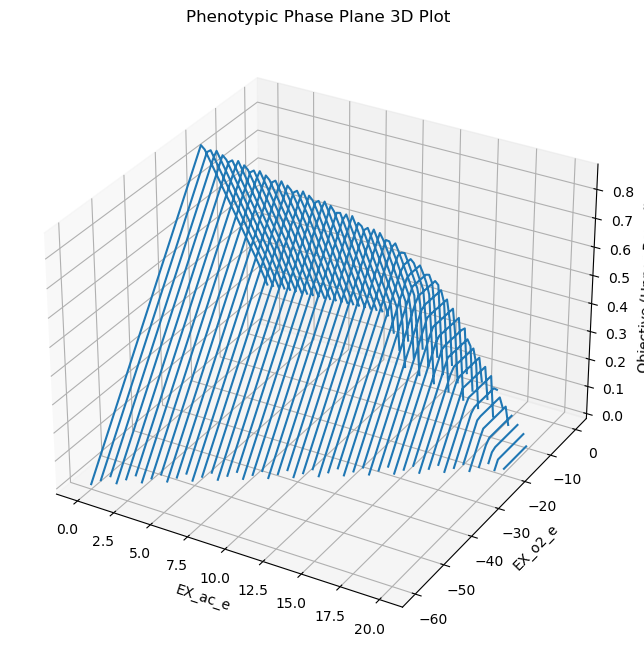

In [31]:

df_3D = result_3D.data_frame

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot EX_ac_e (x), EX_o2_e (y), and objective_upper_bound (z)
ax.plot(df_3D['EX_ac_e'], df_3D['EX_o2_e'], df_3D['objective_upper_bound'], label='Objective Upper Bound')

# Optionally, you could also plot the lower bound:
# ax.plot(df_3D['EX_ac_e'], df_3D['EX_o2_e'], df_3D['objective_lower_bound'], label='Objective Lower Bound')

# Add labels
ax.set_xlabel('EX_ac_e')
ax.set_ylabel('EX_o2_e')
ax.set_zlabel('Objective (Upper Bound)')

# Set a title
ax.set_title('Phenotypic Phase Plane 3D Plot')

# Show the plot
plt.show()

## Exercise (10 min)

* Use `phenotypic_phase_plane` to determine the optimal O2 uptake rate.